In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import segyio
import SegRead as s
import os
import sys
from seislab.src import segyrw 
from seislab.src import plot_seismic
from LAS import Converter
from scipy import signal
from scipy.signal import medfilt
import laspy
from sklearn.linear_model import LinearRegression
from docx import Document
from numpy.linalg import solve
from matplotlib.colors import Normalize
from laspy.file import File
%load_ext autoreload
%autoreload 2

In [2]:
# функция сглаживания в разработке, не используется
def edge_preserving_smooth(sgn,win):
    win_len = win
    o = 0
    signal = sgn.copy()
    for i in np.arange(len(signal)):
        if i < win_len-1:
            o += 1
            pass
        elif i > len(signal)-win_len:
            pass
        else:
            I = []
            Ind1 = []
            Ind2 = []
            std = []
            for j in np.arange(win):
                ind1 = i+j-o
                ind2 = i+j+win_len-o
                I.append(i)
                Ind1.append(ind1)
                Ind2.append(ind2)
                std.append(np.std(signal[ind1:ind2]))
            df = pd.DataFrame({'i':I,'std':std,'ind1':Ind1,'ind2':Ind2})
            b = df.groupby('i')['std'].idxmin()
            b1 = int(df['ind1'][b.values].values)
            b2 = int(df['ind2'][b.values].values)
            signal[i] = signal[b1:b2].mean()
    return signal

# поворот фазы сигнала
def ifft_with_phase(F, x, phase):
    sign = np.ones(len(x))
    sign[np.where(x<0)] = -1*sign[np.where(x<0)]
    sign[np.where(x==0)] = 0
    F_new = np.abs(F)*np.exp(-1j*(np.angle(F)+sign*phase))
    Finv = np.fft.ifft(F_new)
    return np.real(Finv)

# расчет огибающей сигнала
def envelope_calc(Finv):
    hilbert_signal = np.imag(signal.hilbert(Finv))
    envelope = np.sqrt(Finv*Finv+hilbert_signal*hilbert_signal)
    return envelope

## STACK [.sgy]


In [3]:
directory = ''

In [4]:
#прикрутить свою библиотеку

filename = directory+'307_Stk_w1.sgy'


ss = s.Seg.SegReader()
ss.open("307_Stk_w1.sgy")
data = ss.get_data()
data = data.T
data2, head2=ss.get_data_and_trace_heads()

head = segyrw.read_header_segyio_full(filename)
dt = 2 # Дискретизация (считывать из хэдеров?)


Tdata=np.arange(0,np.shape(data)[0]*dt,dt)/1000  # вектор врмеен для сейсмики

In [5]:
head

,SEQWL,CDP_TRACE,CDP_X,CDP_Y,INLINE,XLINE,IDX
0,1716,26196,499775,6637376,800,970,0
1,1717,26197,499800,6637376,800,971,1
2,1718,26198,499825,6637376,800,972,2
3,1719,26199,499850,6637376,800,973,3
4,1720,26200,499875,6637376,800,974,4
...,...,...,...,...,...,...,...
436,1752,58012,500175,6637876,820,986,436
437,1753,58013,500200,6637876,820,987,437
438,1754,58014,500225,6637876,820,988,438
439,1755,58015,500250,6637876,820,989,439


In [6]:
head2

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,CDP_X,CDP_Y,ILINE_NO,XLINE_NO,ShortpointNumber,ScalarValueForShortpointNumber,TraceValueMeasurementUnit,TransductionConstant,spare,IDX
0,1716,0,0,0,0,0,26196,26196,1,0,...,499775,6637376,800,970,0,0,0,0,3632558245580822513320369693797628423243373343...,0
1,1717,0,0,0,0,0,26197,26197,1,0,...,499800,6637376,800,971,0,0,0,0,3632739955261896415043007024749600516116906393...,1
2,1718,0,0,0,0,0,26198,26198,1,0,...,499825,6637376,800,972,0,0,0,0,3632921664942970316765644355701572608990439443...,2
3,1719,0,0,0,0,0,26199,26199,1,0,...,499850,6637376,800,973,0,0,0,0,3633103374624044218488281686653544701863972493...,3
4,1720,0,0,0,0,0,26200,26200,1,0,...,499875,6637376,800,974,0,0,0,0,3633285084305118120210919017605516794737505543...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,1752,0,0,0,0,0,58012,-7524,1,0,...,500175,6637876,820,986,0,0,0,0,3635465600478851092522626387637079639710026545...,436
437,1753,0,0,0,0,0,58013,-7523,1,0,...,500200,6637876,820,987,0,0,0,0,3635647310159924994245263718589051732583559595...,437
438,1754,0,0,0,0,0,58014,-7522,1,0,...,500225,6637876,820,988,0,0,0,0,3635829019840998895967901049541023825457092645...,438
439,1755,0,0,0,0,0,58015,-7521,1,0,...,500250,6637876,820,989,0,0,0,0,3636010729522072797690538380492995918330625695...,439


In [7]:
head

,SEQWL,CDP_TRACE,CDP_X,CDP_Y,INLINE,XLINE,IDX
0,1716,26196,499775,6637376,800,970,0
1,1717,26197,499800,6637376,800,971,1
2,1718,26198,499825,6637376,800,972,2
3,1719,26199,499850,6637376,800,973,3
4,1720,26200,499875,6637376,800,974,4
...,...,...,...,...,...,...,...
436,1752,58012,500175,6637876,820,986,436
437,1753,58013,500200,6637876,820,987,437
438,1754,58014,500225,6637876,820,988,438
439,1755,58015,500250,6637876,820,989,439


In [8]:
%matplotlib notebook
%matplotlib inline

2001


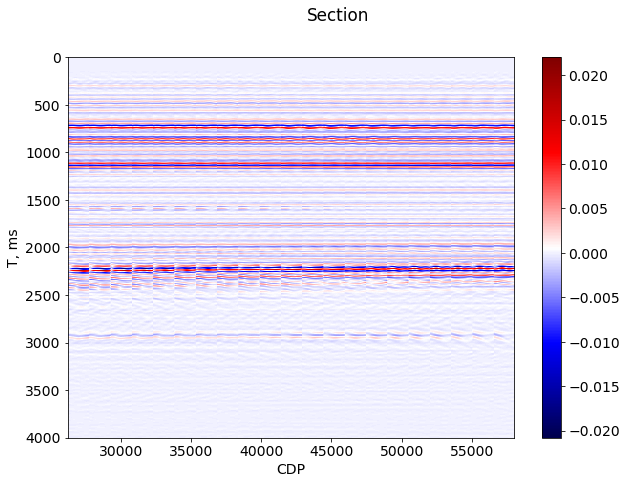

In [9]:

print(data.shape[0])
plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplots(figsize = (10,7))
cs = axs.imshow(data,aspect = 'auto',extent = [head2['CDP_TRACE'].min(),head2['CDP_TRACE'].max(),
                                                                 dt*data.shape[0],0],cmap='seismic')
cs2 = axs.imshow(data,aspect = 'auto',extent = [head['CDP_TRACE'].min(),head['CDP_TRACE'].max(),
                                                                 dt*data.shape[0],0],cmap='seismic')
# ,vmin = -2.5,vmax = 2.5
axs.set_xlabel('CDP')
axs.set_ylabel('T, ms')
fig.suptitle('Section')
fig.colorbar(cs, ax=axs)


2001


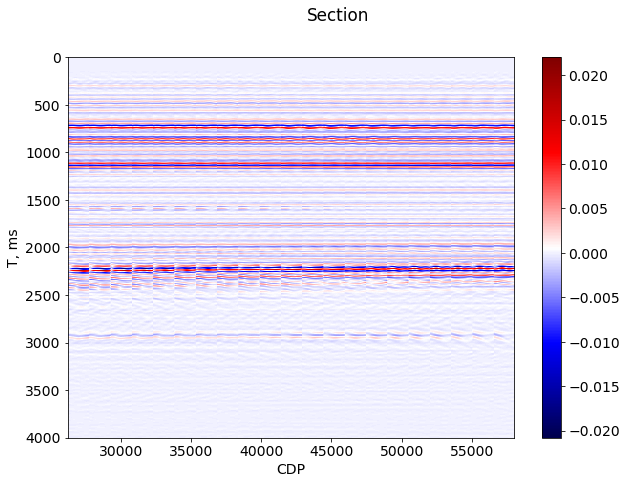

In [10]:

print(data.shape[0])
plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplots(figsize = (10,7))
cs2 = axs.imshow(data,aspect = 'auto',extent = [head['CDP_TRACE'].min(),head['CDP_TRACE'].max(), dt*data.shape[0],0],cmap='seismic')
# ,vmin = -2.5,vmax = 2.5
axs.set_xlabel('CDP')
axs.set_ylabel('T, ms')
fig.suptitle('Section')
fig.colorbar(cs2, ax=axs)


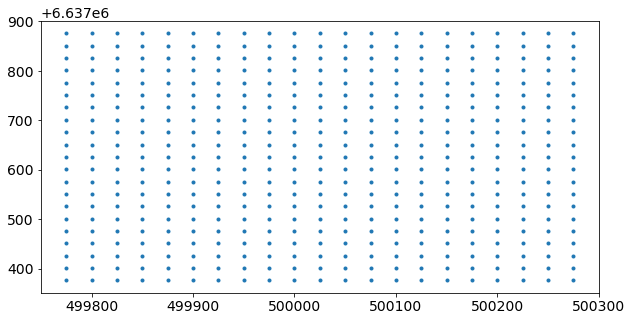

In [11]:
fig,axs = plt.subplots(figsize = (10,5))
axs.plot(head['CDP_X'],head['CDP_Y'],linewidth = 0,marker='.')

## WELL [.las]

In [12]:
c= Converter()
log = c.set_file("Z-Zim-1_TIME.las")
params=log.parameter
#las = liblas.read("307_Stk_w1.sgy")
well_X=params['XCRD']['value']#500001 # координаты скважины (считывать из .las библиотекой ИТСК?)
well_Y=params['YCRD']['value']#6637623
#params['XCRD']['value']#
#params['YCRD']['value']#

In [13]:
well_X,well_Y

(500001.0, 6637623.6)

In [14]:
#удаления сейсмических трасс от скважины

offsets=np.zeros(len(head['CDP_X']))
for ii in range(0, len(head['CDP_X'])):
    offsets[ii]=np.sqrt((well_X-head['CDP_X'][ii])*(well_X-head['CDP_X'][ii])+(well_Y-head['CDP_Y'][ii])*(well_Y-head['CDP_Y'][ii]))

a=np.where(offsets<=np.min(offsets))
offsets_sort=np.argsort(offsets)
# ind_sort=np.where(offsets_sort<=10)

offsets[offsets_sort[0:10]]

array([  2.6       ,  22.62211308,  24.11970149,  26.11053427,
        27.4182421 ,  32.96604314,  34.44938316,  36.42471688,
        37.77247675,  47.61050304])

In [15]:
# считка данных со скважины (использовать библиотеку ИТСК)
c_2= Converter()
log_2 = c_2.set_file("Z-Zim-1jgw.las")
Depth=log_2.data["depth"]  
TVD = log_2.data["tvd"]
TVDSS = log_2.data["tvdss"]
DELTAX = log_2.data["dx"]
DELTAY = log_2.data["dy"]
DTS = log_2.data["dts"]
DT = log_2.data["dt"]
RHOB = log_2.data["rhob"] 

well = pd.DataFrame({'Depth':Depth,'TVD':TVD,'TVDSS':TVDSS,'DELTAX':DELTAX,'DELTAY':DELTAY,'DTS':DTS,'DT':DT,'RHOB':RHOB})

In [16]:
well

,Depth,TVD,TVDSS,DELTAX,DELTAY,DTS,DT,RHOB
0,158.9532,158.9518,113.5218,-0.178953,0.462672,NaN,0.000587,NaN
1,159.1056,159.1042,113.6742,-0.179106,0.463739,NaN,0.000582,NaN
2,159.2580,159.2566,113.8266,-0.179258,0.464806,NaN,0.000578,NaN
3,159.4104,159.4090,113.9790,-0.179410,0.465873,NaN,0.000579,NaN
4,159.5628,159.5614,114.1314,-0.179563,0.466940,NaN,0.000579,NaN
...,...,...,...,...,...,...,...,...
18961,3048.6096,3047.6784,3002.2484,24.185295,10.054864,0.000499,0.000247,2413.7525
18962,3048.7620,3047.8301,3002.4001,24.183618,10.068580,0.000499,0.000249,2460.0000
18963,3048.9144,3047.9819,3002.5519,24.181942,10.082296,0.000499,0.000250,2460.0000
18964,3049.0668,3048.1337,3002.7037,24.180265,10.096012,0.000499,0.000250,2460.0000


In [17]:
# считка закона глубина-время H(T0) (использовать библиотеку ИТСК)
Depth =log.data["depth"]
TVDSS =log.data["tvdss"] 
Time =log.data["time"] 
well_T = pd.DataFrame({'Depth_T':Depth,'TVDSS_T':TVDSS,'Time':Time})

In [18]:
well

,Depth,TVD,TVDSS,DELTAX,DELTAY,DTS,DT,RHOB
0,158.9532,158.9518,113.5218,-0.178953,0.462672,NaN,0.000587,NaN
1,159.1056,159.1042,113.6742,-0.179106,0.463739,NaN,0.000582,NaN
2,159.2580,159.2566,113.8266,-0.179258,0.464806,NaN,0.000578,NaN
3,159.4104,159.4090,113.9790,-0.179410,0.465873,NaN,0.000579,NaN
4,159.5628,159.5614,114.1314,-0.179563,0.466940,NaN,0.000579,NaN
...,...,...,...,...,...,...,...,...
18961,3048.6096,3047.6784,3002.2484,24.185295,10.054864,0.000499,0.000247,2413.7525
18962,3048.7620,3047.8301,3002.4001,24.183618,10.068580,0.000499,0.000249,2460.0000
18963,3048.9144,3047.9819,3002.5519,24.181942,10.082296,0.000499,0.000250,2460.0000
18964,3049.0668,3048.1337,3002.7037,24.180265,10.096012,0.000499,0.000250,2460.0000


In [19]:
well=well.merge(well_T,left_on='Depth', right_on='Depth_T')

In [20]:
# мержим данные по скважине с законом глубина-время
# выбрасываем некорректные данные
ind=well[well['RHOB'] == -999.25 ].index
well=well.drop(ind, axis=0)
well=well.reset_index(drop=True)

In [157]:
class plot_data():#Класс для хранения данных (новое название)
    def __init__(self,x,y,color=None,linewidth=2,label=None):
        #x,y - данные
        #color - цвет
        #label = метка
        #Те же данные, что передаются в plot(x,y,color,lineidth,label)
        self.x=x
        self.y=y
        self.color=color
        self.linewidth = linewidth
        self.label=label
        
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    def get_color(self):
        return self.color
    
    def get_linewidth(self):
        return self.linewidth
    
    def get_label(self):
        return self.label
        

class sub_fig():#Класс отвечающий за один график на канвасе аналог axs[i]
    
    def __init__(self,plots_data=[],#plots_data - Список классов для даты[plot_data_1(),plot_data_2()...]
                 x_lim=[],#[min,max] по x
                 y_lim=[],#[min,max] по y
                 x_label="X",#-меткa по x
                 y_label="Y",#меткa по y
                 title="title",#title
                 fontsize=14,
                 linestyle="-"):#ширина 14
        
        self.plot_data=plots_data
        self.x_label=x_label
        self.y_label=y_label
        self.title=title
        self.fontsize=14
        self.x_lim=x_lim
        self.y_lim=y_lim
        self.linestyle=linestyle
        
    def get_title(self):
        return self.title
           
    def get_fontsize(self):
        return self.fontsize
           
    def get_plot_data(self):
        return self.plot_data
           
    def get_y_label(self):
        return  self.y_label
           
    def get_x_label(self):
        return   self.x_label
    
    def get_y_lim(self):
        return  self.y_lim
           
    def get_x_lim(self):
        return   self.x_lim
    def get_linestyle(self):
        return self.linestyle
    
    
def paint_subplots(nrows=None,ncols=None,figsize=None,layers=[],wspace=0.7,hspace=0.7):
    if(not nrows or not ncols):
        fig,axs = plt.subplots(figsize=figsize)
        axs.plot(layers[0].get_plot_data()[0].get_x(),layers[0].get_plot_data()[0].get_y(),color=layers[0].get_plot_data()[0].get_color(),
                        linewidth=layers[0].get_plot_data()[0].get_linewidth(),label=layers[0].get_plot_data()[0].get_label(),linestyle=layers[0].get_linestyle())
        if(len(layers[0].get_y_lim())>0):
            axs.set_ylim(layers[0].get_y_lim()[0],layers[0].get_y_lim()[1])
        if(len(layers[0].get_x_lim())>0):
            axs.set_xlim(layers[0].get_x_lim()[0],layers[0].get_x_lim()[1])
        axs.set_ylabel(layers[0].get_y_label())
        axs.set_xlabel(layers[0].get_x_label());
        axs.set_title(layers[0].get_title())
        return
        
        
    fig,axs = plt.subplots(nrows,ncols,figsize=figsize)
    for i in range(len(layers)):
        for j in range(len(layers[i].get_plot_data())):
            axs[i].plot(layers[i].get_plot_data()[j].get_x(),layers[i].get_plot_data()[j].get_y(),color=layers[i].get_plot_data()[j].get_color(),
                        linewidth=layers[i].get_plot_data()[j].get_linewidth(),label=layers[i].get_plot_data()[j].get_label(),linestyle=layers[0].get_linestyle())
        if(len(layers[i].get_y_lim())>0):
            axs[i].set_ylim(layers[i].get_y_lim()[0],layers[i].get_y_lim()[1])
        if(len(layers[i].get_x_lim())>0):
            axs[i].set_xlim(layers[i].get_x_lim()[0],layers[i].get_x_lim()[1])
        axs[i].set_ylabel(layers[i].get_y_label())
        axs[i].set_xlabel(layers[i].get_x_label());
        axs[i].set_title(layers[i].get_title())
    plt.subplots_adjust(wspace=wspace,hspace=hspace)

<ipython-input-158-034ecc286c5c>:10: RuntimeWarning: divide by zero encountered in true_divide
  plotdata_2_2= plot_data(2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_H(T0)')


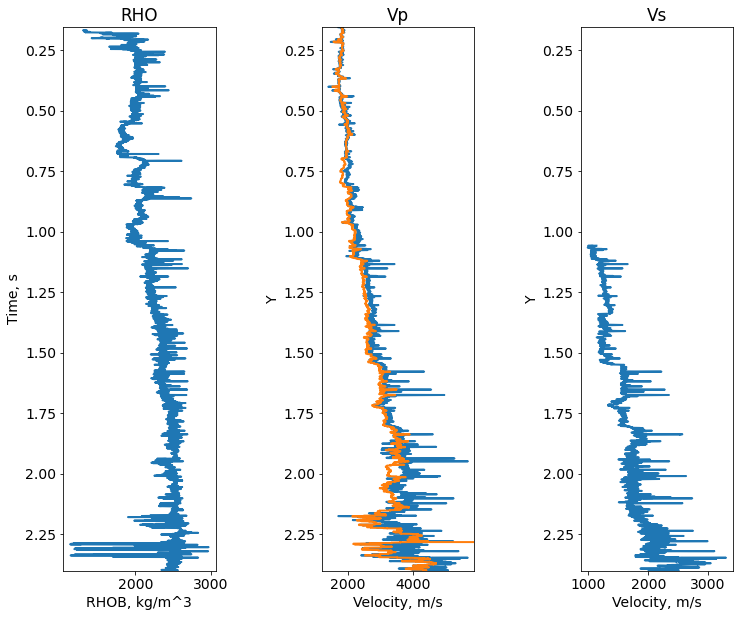

In [158]:
# визуализация скважинных данных от времени (плотность, скорость Вп по акустике/скорость Вп по закону H(T0), скорость Вс)
#че с осями
#Сперва готовим данные, что буди отображать на графике. 1 класс plot_data, грубо говоря, отвечает за одну линию на графике
plotdata_1= plot_data(well['RHOB'],#data x
                      well['Time'],#data y
                      linewidth = 2
                     )
#Допустим на графике по середине две линии plotdata_2_1 и plot_data_2_2
plotdata_2_1= plot_data(1/well['DT'],well['Time'],linewidth = 2,label='V_DT')
plotdata_2_2= plot_data(2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_H(T0)')

plotdata_3=plot_data(1/well['DTS'],well['Time'],linewidth = 2)

layers=[]
#sub_fig(plot_data,...)- один график 
#У нас их три по этому sub_fig() тоже 3
#Один sub_fig опиывает один график
layers.append(sub_fig([plotdata_1],#data
                      y_lim=[well['Time'].max(),well['Time'].min()],#limits
                      x_label="RHOB, kg/m^3",#x label
                      y_label="Time, s",#y label
                      title="RHO"#title
                     ))
layers.append(sub_fig([plotdata_2_1,plotdata_2_2],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[1200,5900],title="Vp",x_label="Velocity, m/s"))
layers.append(sub_fig([plotdata_3],y_lim=[well['Time'].max(),well['Time'].min()],x_label='Velocity, m/s',title="Vs"))
        
#Передаём количество графиков (1 строка 3 ряда), размер фигуры, слои
paint_subplots(1,3,figsize = (12,10),layers=layers)

<ipython-input-159-f159a94ce190>:3: RuntimeWarning: divide by zero encountered in true_divide
  plotdata_1=plot_data(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_DT')
<ipython-input-159-f159a94ce190>:4: RuntimeWarning: divide by zero encountered in true_divide
  dV_otn=(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']))*100/(1/well['DT'][1:])


inf

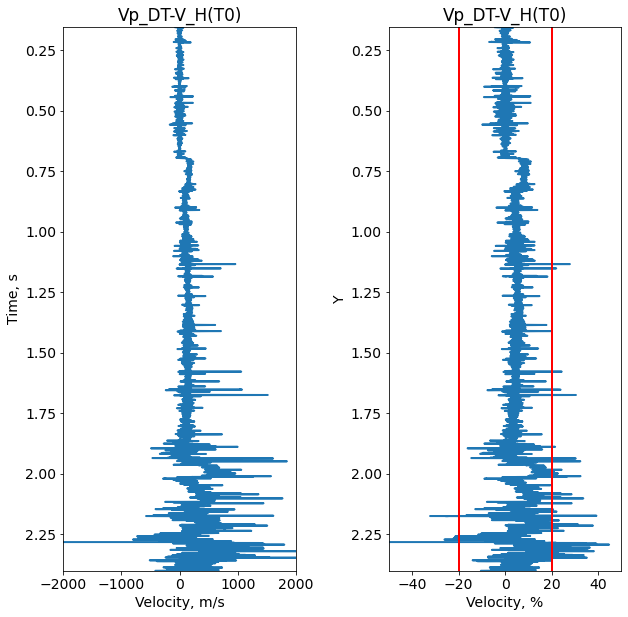

In [159]:
# визуализация разницы скоростей по акустике, по H(T0)

plotdata_1=plot_data(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_DT')
dV_otn=(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']))*100/(1/well['DT'][1:])
plotdata_2=plot_data(dV_otn,well['Time'][1:],linewidth = 2,label='dV_%')
plotdata_2_1=plot_data([-20, -20],[well['Time'].max(), well['Time'].min()],color='r')
plotdata_2_2=plot_data([20, 20],  [well['Time'].max(), well['Time'].min()],color='r')
layers=[]
layers.append(sub_fig([plotdata_1],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-2000,+2000],x_label='Velocity, m/s',y_label="Time, s",title="Vp_DT-V_H(T0)"))
layers.append(sub_fig([plotdata_2,plotdata_2_1,plotdata_2_2],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-50,50],x_label='Velocity, %',title="Vp_DT-V_H(T0)"))
paint_subplots(1,2,figsize = (10,10),layers=layers,wspace=0.4)    
np.max(abs(dV_otn))

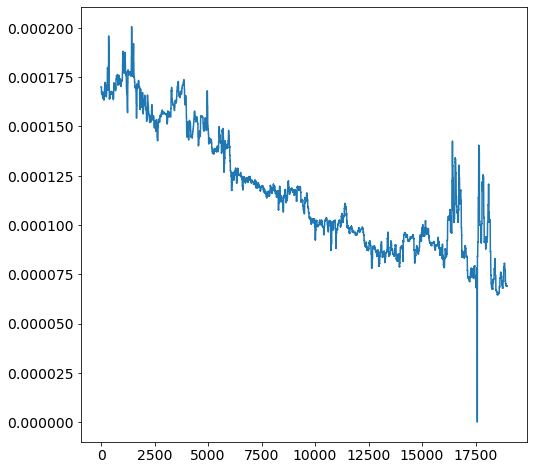

In [160]:
fig,axs = plt.subplots(figsize = (8,8))
axs.plot(np.diff(well['Time']))

In [161]:
# расчет коэффициентов отржаения по скважине (через Вп и плотность)

well['Reflectivity']=0.0

for ii in range(0,len(well['Time'])-1):
    well['Reflectivity'][ii]=((1/well['DT'][ii])*well['RHOB'][ii]-(1/well['DT'][ii+1])*well['RHOB'][ii+1])/((1/well['DT'][ii])*well['RHOB'][ii]+(1/well['DT'][ii+1])*well['RHOB'][ii+1])

    

# вектор времен для данных со скважины (определять dt по среденему dt из закона H(T0))

T_well=np.arange(Tdata[0],Tdata[-1],0.0001)

Refl_int=np.interp(T_well,well['Time'],well['Reflectivity'])
Seism_sig=np.interp(T_well,Tdata,np.squeeze(data[:,a[0]]))

In [162]:
well['Reflectivity']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
18961   -0.006307
18962    0.001900
18963    0.000704
18964    0.000000
18965    0.000000
Name: Reflectivity, Length: 18966, dtype: float64

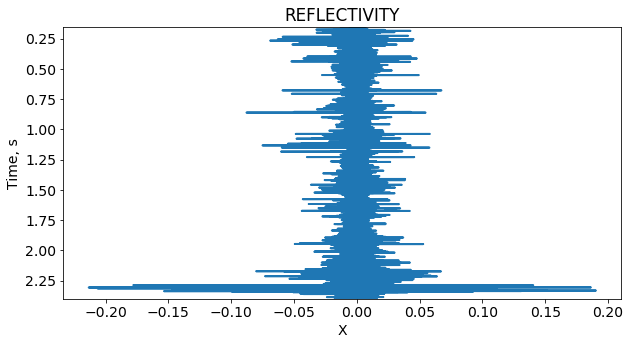

In [163]:
# визуализация коэффициентов отржажения
layers=[]
plot_data_1=plot_data(well['Reflectivity'],well['Time'],linewidth = 2)

layers.append(sub_fig([plot_data_1],y_lim=[well['Time'].max(),well['Time'].min()], y_label="Time, s",title="REFLECTIVITY"))
paint_subplots(figsize = (10,5),layers=layers,wspace=0.4)


In [164]:
class DataCsv():
        def __init__(self,path):
            with open(path,"r") as file:
               i=0
               flag=False
               for line in file:
                   if(line[0:2]=='"*'):
                       continue
                   else:break
               self.info=line
               self.start_time_or_depth=float(file.readline())
               self.sample_interval=float(file.readline())
               self.N = int(file.readline())
               self.data=np.array( [float(i) for i in list(file)])



In [165]:
def test(path,start,stop,dt):
    #чекнуть linspace, а не arange
   return  T_int2,Sig=np.interp(T_int2,T,D.data)

SyntaxError: invalid syntax (<ipython-input-165-249206c7bd3f>, line 3)

## Impulse [.xls]

In [ ]:
# загрузка импульса (сделать через xls)
D=DataCsv("Multi_wavelets.csv")

# pd.read_excel('tmp.xlsx', index_col=0)  

T=np.arange(D.start_time_or_depth,D.start_time_or_depth+(D.N)*D.sample_interval,D.sample_interval) # вектор времени из заголовков xls
T_int2=np.arange(-0.2,0.2,0.0001) # вектор времен с дискретизацией по скважине и дополнение нулями для норм спектров

# Sig=[]
# f= open("ss.txt")
# for line in f.readlines():
#     Sig.append(np.float(line.split()[0]))

    
Sig=np.interp(T_int2,T,D.data)
# f.close

In [ ]:
print(T,T.shape)

In [ ]:
# визуализация сигнала

fig,axs = plt.subplots(figsize = (10,5))
axs.plot(T_int2,Sig,linewidth = 2)

axs.set_xlabel('Time, s')
axs.set_ylabel('Amplitude');
axs.set_title('Signal')

## Расчет метрик

In [ ]:
# осреднение данных по сейсмике для нормальных спектров (нужно в каком то радиусе, тут для всей сейсмики)

Seism_sig_mean=np.zeros(np.shape(data)[0])
for ii in range(0,np.shape(data)[0]):
    Seism_sig_mean[ii]=np.mean(data[ii,:])


Seism_sig_mean=np.interp(T_well,Tdata,Seism_sig_mean)
    
# выделение целевого интервала (это входной параметр для всего инструмента)

Seism_sig_mean[0:10000]=0
Seism_sig_mean[24000:-1]=0

In [ ]:
# визуализация осредненной трассы по сейсмике

fig, axs = plt.subplots(figsize = (10,8))
axs.plot(Seism_sig_mean)

In [ ]:
# fig, axs = plt.subplots(figsize = (10,8))

# dt=0.0001
# F = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(Refl_int)))
# x = np.fft.ifftshift(np.fft.fftfreq(len(Refl_int),dt))
# z=np.angle(F)


# axs.plot(x,F)
# axs.set_xlim(0,100)

In [175]:
def diff_1__3__2(x,ind2,ind3):
    return x[ind3]-x[ind2]



In [176]:

def Pha(x,z):
    
    ind = np.squeeze(np.where(x>0))
    x=x[ind]
    ind2 = np.squeeze(np.where(x<=60))#x.max x.min<=x[ind]<=x.max
    x_apr = x[ind2]#0..60
    print(z[ind])
    reg1 = LinearRegression().fit(x_apr.reshape(-1, 1), z[ind[ind2]].reshape(-1, 1))
    z_apr = reg1.coef_*x_apr.reshape(-1, 1)+reg1.intercept_
    z_apr_extr=reg1.intercept_[0]

    Phase=np.round(z_apr_extr,2)#фаза
    A=(np.round(reg1.coef_[0][0],3))#Наклоны
    
    return Phase,A

In [177]:

def Freq(x,F):
    z=np.angle(F)
    ind = np.squeeze(np.where(x>0))#>=0
    x=x[ind]
    F=F[ind]
    
    ind2 = np.argmax(np.abs(F))#Доминантная частота сигнала(максимум графика)(index)
    ind3 = np.squeeze((np.where(np.abs(F)<np.abs(F[ind2])*20/100)))#20% от максимума графика
    
    Dom=x[ind2]#Доминантная частота сигнала
    Ampl_Dom=F[ind2]#Амплитуда доминантной частоты
    
    ind_x=np.array([],dtype='int')
    diff=diff_1__3__2(x,ind2,ind3)
    ind_x=np.append(ind_x,np.squeeze(np.where(diff<0)))
    
    if len(ind_x)==0:
        x_min=0
    else:
        x_min=x[ind3[ind_x[np.argmax(x[ind3[ind_x]]-x[ind2])]]]
        
    ind_x=np.array([],dtype='int')
    ind_x=np.append(ind_x,np.squeeze(np.where(diff>0)))
    
    x_max=x[ind3[ind_x[np.argmin(x[ind3[ind_x]]-x[ind2])]]]
    Width=(x_max-x_min)#Ширина колокола
    
    return Dom,Ampl_Dom,x_min,x_max,Width

In [166]:
# #вот тут жоско криво
# # расчет амплитудных и фазовых спектров сигнала и сесмической трассы и снятие метрик
# #(мин частота, макс частота, доминантная частота)

# dt=0.0001
# F = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(Sig)))
# x = np.fft.ifftshift(np.fft.fftfreq(len(Sig),dt))#Частоты
# z=np.angle(F)

# Dom,Ampl_Dom,x_min,x_max,Width=Freq(F,x)

# # ind = np.squeeze(np.where(x>0))#>=0
# # x=x[ind]
# # F=F[ind]
# # #x= x[ind]можно убирать 
# # #тОЖЕ ОТСЕЧЬ МОЖНО
# # ind2 = np.argmax(np.abs(F[ind]))#Доминантная частота сигнала(максимум графика)(index)

# # ind3 = np.squeeze((np.where(np.abs(F)<np.abs(F[ind2])*20/100)))#20% от максимума графика

# # Dom=x[ind2]#Доминантная частота сигнала
# # Ampl_Dom=F[ind2]#Амплитуда доминантной частоты

# # ind_x=np.array([],dtype='int')
# # #
# # diff=diff_1__3__2(x,ind2,ind3)

# # #найти пересечение линии жёлтой и синей
# # ind_x=np.append(ind_x,np.squeeze(np.where(diff<0)))
# # #ind_x=np.append(ind_x,np.squeeze(np.where((x[ind[ind3]]-x[ind[ind2]])<0)))
# # print(ind_x)

# # if len(ind_x)==0:
# #     x_min=0
# # else:
# #     x_min=x[ind3[ind_x[np.argmax(x[ind3[ind_x]]-x[ind2])]]]


# # ind_x=np.array([],dtype='int')
# # ind_x=np.append(ind_x,np.squeeze(np.where(diff>0)))

# # x_max=x[ind3[ind_x[np.argmin(x[ind3[ind_x]]-x[ind2])]]]

# # Width=(x_max-x_min)#Ширина колокола


# #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# ind = np.squeeze(np.where(x>0))
# ind2 = np.squeeze(np.where(x[ind]<=60))#x.max x.min<=x[ind]<=x.max
# x_apr = x[ind[ind2]]#0..60

# reg1 = LinearRegression().fit(x_apr.reshape(-1, 1), z[ind[ind2]].reshape(-1, 1))
# z_apr = reg1.coef_*x_apr.reshape(-1, 1)+reg1.intercept_
# z_apr_extr=reg1.intercept_[0]

# Phase=np.round(z_apr_extr,2)#фаза
# A=(np.round(reg1.coef_[0][0],3))#Наклоны
    
# # a=Ampl_Dom
# # b=Dom
# # c=Width/4
# # gaus=a*np.exp(-(x-b)**2/(2*c**2))
    

# fig, axs = plt.subplots(2,1,figsize = (10,8))
# axs[0].plot(x,np.max(F)*np.ones(np.shape(x))*0.2)
# axs[0].plot(x,np.abs(F),'.-',label = 'Signal_well')
# #axs[0].plot(x,gaus)
# axs[0].set_xlim(0,100)

# axs[0].set_xlabel('Freaquency, s')
# axs[0].set_ylabel('Amplitude');



# dt=0.0001
# F2 = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(Seism_sig)))
# x2 = np.fft.ifftshift(np.fft.fftfreq(len(Seism_sig),dt))

# Dom2,Ampl_Dom2,x_min,x_max,Width=Freq(x2,F2)
# #axs[0].plot(x2,np.abs(F2)*650/np.max(np.abs(F2)),'.-',label = 'seismic')
# #F2=medfilt(np.abs(F2)*650/np.max(np.abs(F2)),45)
# #axs[0].plot(x2,F2,'.-',label = 'seismic_smooth')


# # ind = np.squeeze(np.where(x2>=0))
# # ind2 = np.argmax(np.abs(F2[ind]))
# # ind3 = np.squeeze((np.where(np.abs(F2[ind])<np.abs(F2[ind[ind2]])*20/100)))

# # Dom2=x2[ind[ind2]]
# # Ampl_Dom2=F2[ind[ind2]]

# # ind_x=np.array([],dtype='int')
# # ind_x=np.append(ind_x,np.squeeze(np.where((x2[ind[ind3]]-x2[ind[ind2]])<0)))
# # if len(np.squeeze(np.where((x2[ind[ind3]]-x2[ind[ind2]])<0)))==0:
# #     x_min2=0
# # else:
# #     x_min2=x2[ind[ind3[ind_x[np.argmax(x2[ind[ind3[ind_x]]]-x2[ind[ind2]])]]]]


# # ind_x=np.array([],dtype='int')
# # ind_x=np.append(ind_x,np.squeeze(np.where((x2[ind[ind3]]-x2[ind[ind2]])>0)))
# # x_max2=x2[ind[ind3[ind_x[np.argmin(x2[ind[ind3[ind_x]]]-x2[ind[ind2]])]]]]

# # Width=(x_max2-x_min2)

# axs[0].set_title('Ampl_spectre, min_s = ' + str(x_min) + ', max_s = ' + str(x_max) + ', min_seis = ' + str(x_min2) + ', max_seis = ' + str(x_max2))
# axs[0].legend()



# # фазовый спектр только для сигнала функция по фазовым спектрам то же предполагает расчет метрик (добавить)
# axs[1].plot(x,z,'.-')
# axs[1].set_title('Phase_spectre')
# axs[1].set_xlabel('Freaquency, Hz')
# axs[1].set_xlim(0,100)

[-0.98271851 -0.90972136 -0.72591809 ...,  0.41086893  2.75857999
  0.0409328 ]
[-40.   -5.    2.5  37.5] [ 60.09629374+2.95068259j  60.09629374+2.95068259j  60.09629374+2.95068259j
  60.09629374+2.95068259j]


c:\users\kognor\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


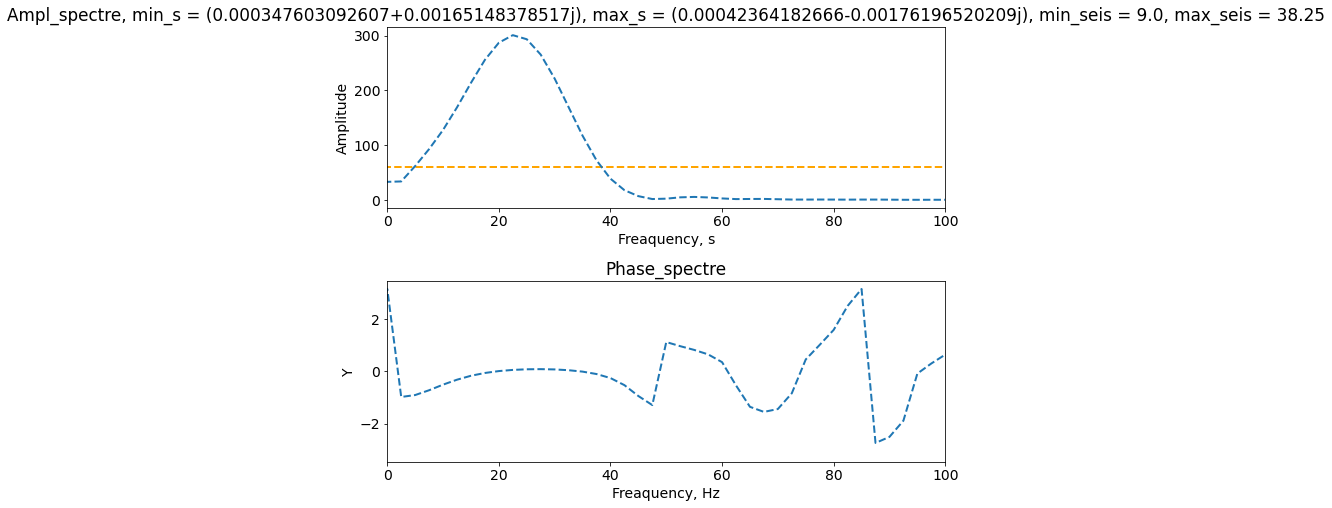

In [174]:
#Новая версия страшного блока
from scipy.optimize import fsolve

def findIntersection(fun1,fun2,x0):
    return fsolve(lambda x : fun1(x) - fun2(x),x0)


dt=0.0001
F = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(Sig)))
x = np.fft.ifftshift(np.fft.fftfreq(len(Sig),dt))#Частоты
z=np.angle(F)
Dom,Ampl_Dom,x_min,x_max,Width=Freq(F,x)

Phase,A=Pha(x,z)

dt=0.0001
F2 = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(Seism_sig)))
x2 = np.fft.ifftshift(np.fft.fftfreq(len(Seism_sig),dt))
Dom2,Ampl_Dom2,x_min_2,x_max_2,Width=Freq(x2,F2)

f=np.max(F)*np.ones(np.shape(x))*0.2
g=np.abs(F)
plotdata_1=plot_data(x,f,color='orange')
plotdata_2=plot_data(x,g,label = 'Signal_well')


idx = np.argwhere(np.diff(np.sign(f - g))).ravel()
print(x[idx],f[idx])

plotdata_3=plot_data(x,z)
layers=[]
layers.append(sub_fig([plotdata_1,plotdata_2],x_lim=[0,100],x_label='Freaquency, s',y_label="Amplitude",linestyle="--",title='Ampl_spectre, min_s = ' + str(x_min) + ', max_s = ' + str(x_max) + ', min_seis = ' + str(x_min2) + ', max_seis = ' + str(x_max2)))
layers.append(sub_fig([plotdata_3],x_lim=[0,100],x_label='Freaquency, Hz',title="Phase_spectre"))
paint_subplots(2,1,figsize = (10,8),layers=layers,wspace=0.4,hspace=0.4)   


In [94]:
np.array([[1,0,1,0,0,1],[1,1,0,1,0,1], [1,1,0,0,1,0]]).T


array([[1, 1, 1],
       [0, 1, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 1, 0]])

In [91]:
# СВЕРТКА СИГНАЛА И КОЭФФИЦИЕНТОВ ОТРАЖЕНИЯ

res=np.convolve(Refl_int, Sig, mode='same')
# res2=np.convolve(Refl_int, signal, mode='same')

Text(0.5, 1.0, 'Коэф. отраж')

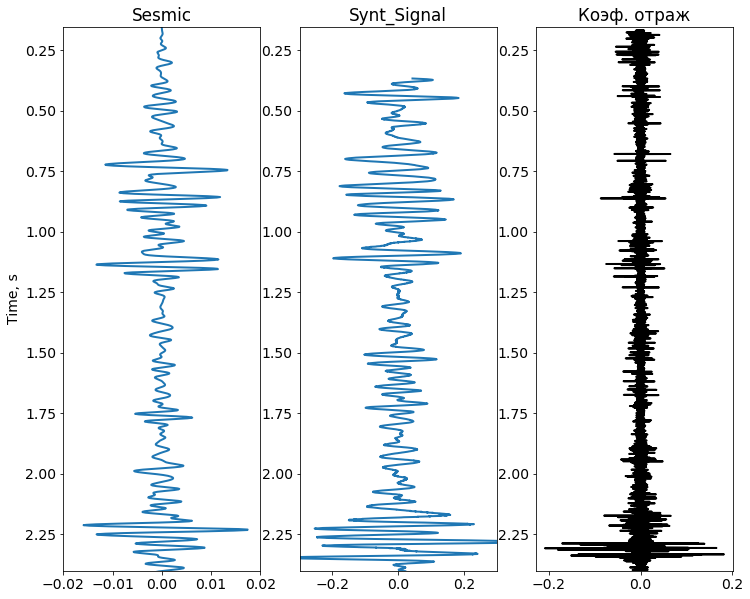

In [92]:
# визуализация ближней к скважине сейсмической трассы, свертки из прошлого блока, коэффициентов отражения

fig,axs = plt.subplots(1,3,figsize = (12,10))
# axs2=plt.subplots(2,2,2)
axs[0].plot(Seism_sig,T_well,linewidth = 2)
axs[0].invert_yaxis()
axs[0].set_ylim(well['Time'].max(),well['Time'].min())
axs[0].set_xlim(-0.02,0.02)
axs[0].set_ylabel('Time, s')
axs[0].set_title('Sesmic')

axs[1].plot(res,T_well,linewidth = 2)
axs[1].invert_yaxis()
axs[1].set_ylim(well['Time'].max(),well['Time'].min())
axs[1].set_xlim(-0.3,0.3)
axs[1].set_title('Synt_Signal')

axs[2].plot(Refl_int,T_well,linewidth = 2,color = 'k')
axs[2].invert_yaxis()
axs[2].set_ylim(well['Time'].max(),well['Time'].min())
axs[2].set_title('Коэф. отраж')

0.734652907375
238
332


Text(0.5, 1.0, 'FVK 1-2.4s, KK = -0.4, KK_max = 0.73, KKdt = 23.8 ms, Edt = 33.2 ms')

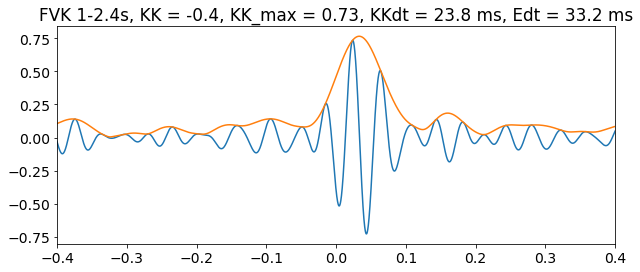

In [42]:
# ФВК трассы сейсмики(не осредненной) и скважины, расчет метрик 

fig,axs = plt.subplots(figsize = (10,4))
Seism_sig2=Seism_sig.copy()
res2=res.copy()
Seism_sig2[0:10000]=0 # выделение целевого интервала
Seism_sig2[24000:-1]=0
res2[0:10000]=0
res2[22500:-1]=0

resC=np.correlate(Seism_sig2, res2, mode='full')
resC=resC/(np.std(Seism_sig2)*np.std(res2)*len(res2))
resE=envelope_calc(resC)

KK0=(np.mean(Seism_sig2*res2)-np.mean(Seism_sig2)*np.mean(res2))/(np.std(res2)*np.std(Seism_sig2))
KK=resC[np.argmax(np.abs(resC))]
KKdt=np.argmax(resC)-len(res2)+1
Edt=np.argmax(resE)-len(res2)+1


print(KK)
print(KKdt)
print(Edt)

axs.plot(np.arange(-len(res2)+1,len(res2),1)*0.0001,resC)
axs.plot(np.arange(-len(res2)+1,len(res2),1)*0.0001,resE)
axs.set_xlim(-0.4,0.4)
axs.set_title('FVK 1-2.4s, KK = ' + str(np.round(KK0,2)) + ', KK_max = ' + str(np.round(KK,2)) + ', KKdt = ' + str(KKdt/10) + ' ms, Edt = ' + str(Edt/10) + ' ms')


In [43]:
# подготовка данных для норм визуализации (10 повторяющихся трасс со скважины, 10 ближайших к скважине трасс)

data_near_well_synt=np.zeros((len(res),10))
for ii in range(0,10):
    data_near_well_synt[:,ii]=res
    
    
data_near_well=np.zeros((len(res),10)) 
for ii in range(0,10):
    data_near_well[:,ii]=np.interp(T_well,Tdata,np.squeeze(data[:,offsets_sort[ii]]))
    

(2.4005392, 0.16606695)

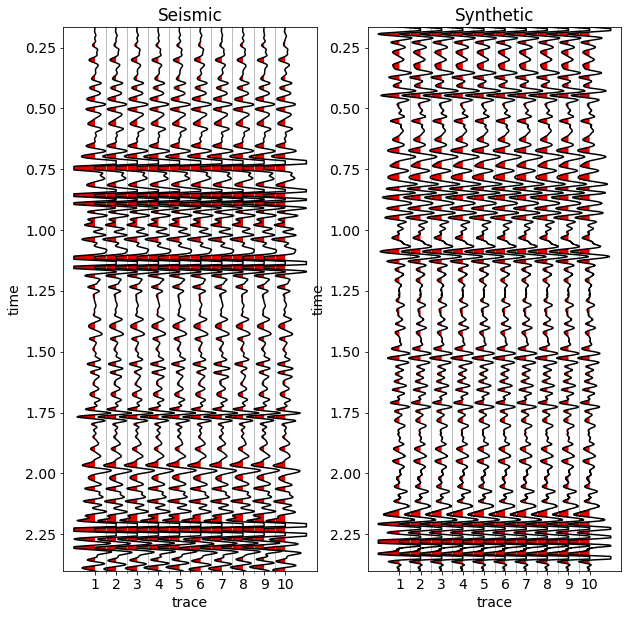

In [44]:
# проверка визуализации предыдущего блока

fig,axs = plt.subplots(1,2,figsize = (10,10))


plot_seismic.plot_traces(
    data_near_well.T, time_vertical=True, trace_color='k', 
    invert_y_axis=True,dt = 0.0001,
    fill_positive = True,
    fig_width=8,
    gain=5,
    clip=1,
    alpha = 1,
    ax=axs[0]
)

plot_seismic.plot_traces(
    data_near_well_synt.T, time_vertical=True, trace_color='k', 
    invert_y_axis=True,dt = 0.0001,
    fill_positive = True,
    fig_width=8,
    gain=4,
    clip=1,
    alpha = 1,
    ax=axs[1]
)

axs[0].set_title('Seismic')
axs[1].set_title('Synthetic')
axs[0].set_ylim(well['Time'].max(),well['Time'].min())
axs[1].set_ylim(well['Time'].max(),well['Time'].min())

In [45]:
# расчет КК (сейсмика-синтетика) в окне (подложка для визуализации)
win=1000
data_KK=np.zeros((len(res),10))
sig1=[]     
sig2=[]
corr12=[]                 
ttt=[]

for jj in range(0,10):
    for ii in range(win,len(res)-win):
        
        sig1=data_near_well[(ii-win):(ii+win),jj]
        sig2=data_near_well_synt[(ii-win):(ii+win),jj]
        ttt=np.arange(-len(sig1)+1,len(sig1),1)*0.0001
        
        data_KK[ii,jj]=(np.mean(sig1*sig2)-np.mean(sig1)*np.mean(sig2))/(np.std(sig2)*np.std(sig1))
#         corr12=np.correlate(sig1, sig2, mode='full')
#         corr12=corr12/(np.std(sig1)*np.std(sig2)*len(sig2))
        
#         data_KK[ii,jj]=corr12[np.argmax(np.abs(corr12))]
#         data_KK[ii,jj]=corr12[int(np.floor(len(ttt)/2))]
#         data_KK[ii,jj]=corr12[np.argmax(corr12)]
        


<ipython-input-45-3b189af1f60f>:16: RuntimeWarning: invalid value encountered in double_scalars
  data_KK[ii,jj]=(np.mean(sig1*sig2)-np.mean(sig1)*np.mean(sig2))/(np.std(sig2)*np.std(sig1))


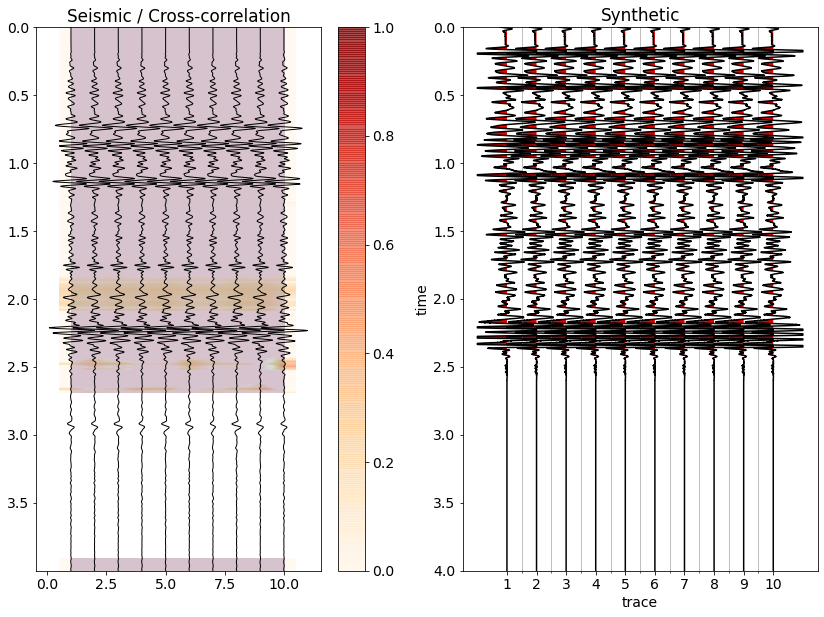

In [46]:
# визуализация предыдущего блока с трассами

fig,axs = plt.subplots(1,2,figsize = (14,10))


# alphas = Normalize(0, .2, clip=True)(np.abs(data_KK))
# alphas = np.clip(alphas, .2, 1)  # alpha value clipped at the bottom at .4



plot_seismic.plot_traces(
    data_near_well_synt.T, time_vertical=True, trace_color='k', 
    invert_y_axis=True,dt = 0.0001,
    fill_positive = True,
    fig_width=8,
    gain=5,
    clip=1,
    alpha = 1,
    ax=axs[1]
)
for ii in range(0,10):
    axs[0].plot(data_near_well[:,ii]/np.max(data_near_well[:,ii]).T+ii+1,T_well,'k',alpha=1,zorder=1,lw=1)
    
axs[0].imshow(data_KK,aspect = 'auto',vmin=0,vmax=1,extent=[1,10,T_well[-1],T_well[0]],alpha=0.7)
axs[0].set_title('Seismic / Cross-correlation')
axs[1].set_title('Synthetic')

cs=axs[0].imshow(data_KK,aspect = 'auto',vmin=0,vmax=1,extent=[0.5,10.5,T_well[-1],T_well[0]],alpha=0.7,cmap='OrRd')
# plt.set_cmap('OrRd')
# plt.set_cmap('brg')
fig.colorbar(cs, ax=axs[0])


# axs[0].plot(data_near_well[:,0]/np.max(data_near_well[:,0]).T+5,T_well,'k')
# np.linspace(0,10),T_well,
# np.linspace()

## мусор

<IPython.core.display.Javascript object>


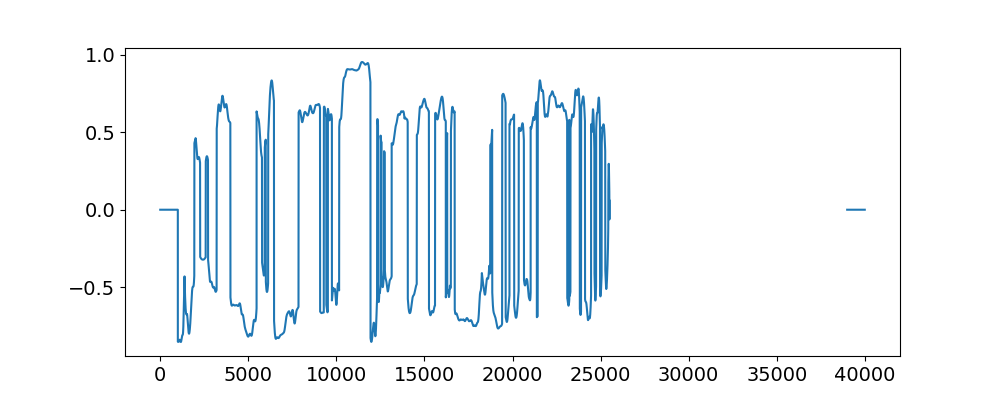

In [535]:
fig,axs = plt.subplots(figsize = (10,4))

axs.plot(data_KK[:,2])

In [404]:

# data_near_well=res

In [403]:
np.shape(data_near_well)

(40000, 10)

In [360]:
offsets[offsets_sort[0:10]]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

<IPython.core.display.Javascript object>


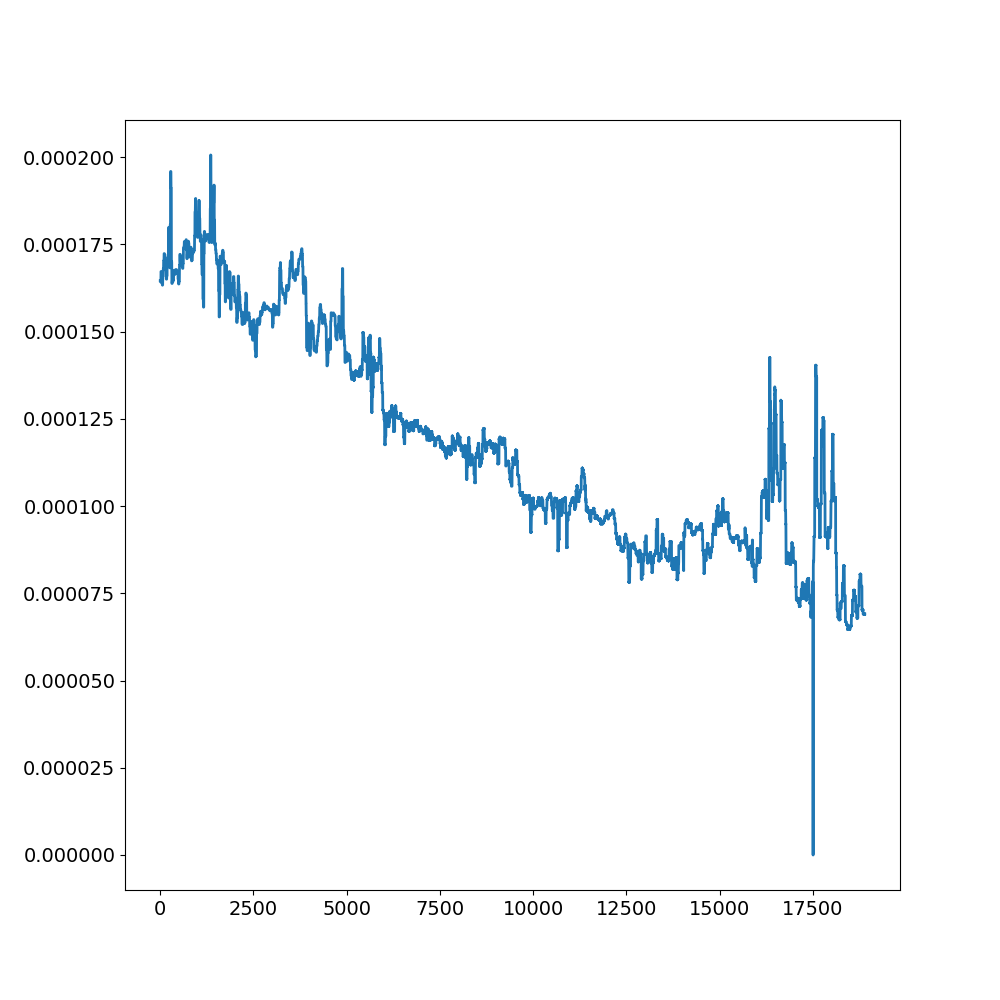

In [175]:
fig,axs = plt.subplots(1,1,figsize = (10,10))

axs.plot(np.diff(well['Time']),linewidth = 2)

In [208]:
filename1='w1_cdp.sgy'

In [564]:
f = segyio.open(filename1, ignore_geometry = True)
data2 = segyio.tools.collect(f.trace[:])
data2 = data2.T

In [212]:
%matplotlib notebook

<IPython.core.display.Javascript object>


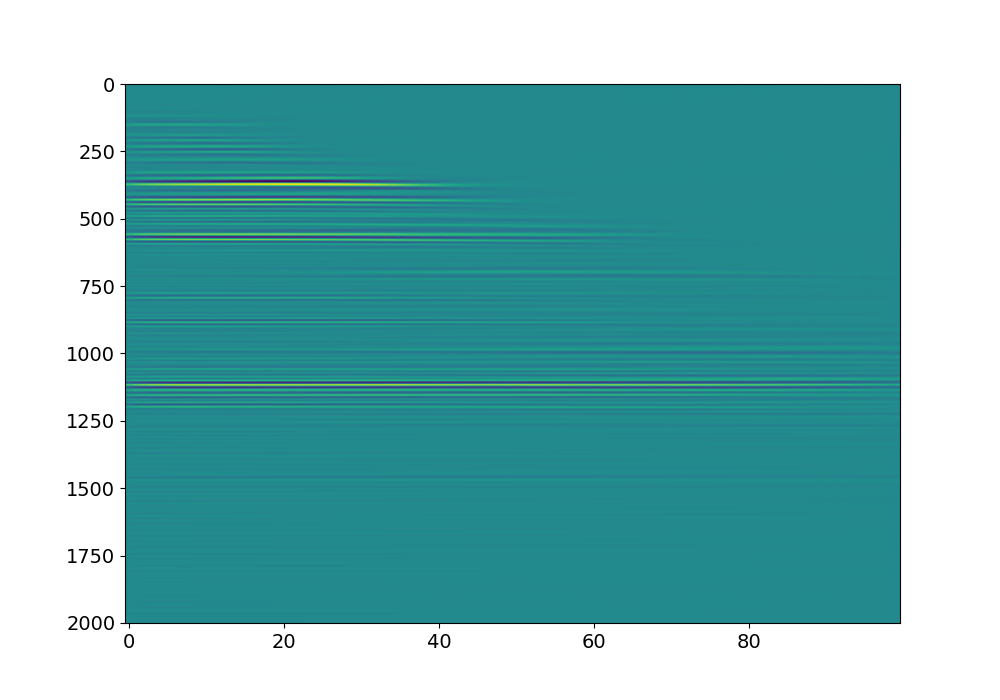

In [568]:
# plot_seismic.plot_traces(
#     data2[:,0:100].T, time_vertical=True, trace_color='k', 
#     invert_y_axis=True,dt = 2.0,
#     fill_positive = True,
#     fig_width=8,
#     gain=5,
#     clip=1,
#     alpha = 1,
# )

fig,axs = plt.subplots(figsize = (10,7))
axs.imshow(data2[:,0:100],aspect = 'auto')

In [220]:
 data[:,0]

array([  1.40300108e-06,   1.76512276e-06,   1.55869566e-06, ...,
         1.27704634e-05,   2.36795895e-05,   3.16007645e-05], dtype=float32)